In [365]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

In [366]:
## all required packages can go in this cell ##
import matplotlib
%matplotlib inline

from pycbc.waveform import get_td_waveform, td_approximants, fd_approximants, get_fd_waveform
import pylab
from pycbc import types, fft,waveform, filter,noise
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib.widgets import Slider, Button
from pycbc.psd import interpolate, inverse_spectrum_truncation, welch
from pycbc.filter import matched_filter
#from ipywidgets import interact, interact_manual
from pycbc import psd
from pycbc.filter import resample_to_delta_t, highpass
import pycbc.psd, pycbc.noise
import pylab
from math import pi
#states no module #import pandas as pd

from pycbc.detector import Detector

import decimal


import lalsimulation

import lal
import pandas as pd

In [367]:
#Citation; Ian Harry, University of Portsmouth ICG #

from pycbc.filter.matchedfilter import make_frequency_series, matched_filter_core, zeros
from pycbc.filter.matchedfilter import sigmasq, complex_same_precision_as, sqrt

_snr = None
def match(vec1, vec2, psd=None, low_frequency_cutoff=None,
          high_frequency_cutoff=None, v1_norm=None, v2_norm=None):
    """ Return the match between the two TimeSeries or FrequencySeries.
    Return the match between two waveforms. This is equivalent to the overlap
    maximized over time and phase.
    Parameters
    ----------
    vec1 : TimeSeries or FrequencySeries
        The input vector containing a waveform.
    vec2 : TimeSeries or FrequencySeries
        The input vector containing a waveform.
    psd : Frequency Series
        A power spectral density to weight the overlap.
    low_frequency_cutoff : {None, float}, optional
        The frequency to begin the match.
    high_frequency_cutoff : {None, float}, optional
        The frequency to stop the match.
    v1_norm : {None, float}, optional
        The normalization of the first waveform. This is equivalent to its
        sigmasq value. If None, it is internally calculated.
    v2_norm : {None, float}, optional
        The normalization of the second waveform. This is equivalent to its
        sigmasq value. If None, it is internally calculated.
    Returns
    -------
    match: float
    index: int
        The number of samples to shift to get the match.
    """

    htilde = make_frequency_series(vec1)
    stilde = make_frequency_series(vec2)

    N = (len(htilde)-1) * 2

    global _snr
    if _snr is None or _snr.dtype != htilde.dtype or len(_snr) != N:
        _snr = zeros(N,dtype=complex_same_precision_as(vec1))
    snr, _, snr_norm = matched_filter_core(htilde,stilde,psd,low_frequency_cutoff,
                             high_frequency_cutoff, v1_norm, out=_snr)
    maxsnr, max_id = snr.abs_max_loc()
    if max_id == 0:
        left = abs(snr[-1])
    else:
        left = abs(snr[max_id - 1])
    middle = maxsnr
    if max_id == len(snr) - 1:
        right = abs(snr[0])
    else:
        right = abs(snr[max_id + 1])
   
    def quadratic_interpolate_peak2(ym1, y, yp1):
        dy = 0.5 * (yp1 - ym1);
        d2y = 2. * y - ym1 - yp1;
        return y + 0.5 * dy * dy / d2y;

       
    if v2_norm is None:
        v2_norm = sigmasq(stilde, psd, low_frequency_cutoff, high_frequency_cutoff)

    peak_value = quadratic_interpolate_peak2(left, middle, right)

    return peak_value * snr_norm / sqrt(v2_norm), max_id

In [369]:
i = 0
Tidal_Deformation = 0
a = [] #overlap 
b = [] #tidal deform
c = [] #SNR

e = [] #overlap ET 
f = [] #SNR

h = [] #overlap CE
k = [] #SNR

end_time =  1187008882.4  
declination = 0.2617993878 
right_ascension = 0.03490658504   
polarization = 1 

det_h1 = Detector('H1')
det_l1 = Detector('L1')

for i in range(101):
    hp, hc = get_fd_waveform(approximant='TaylorF2',
                         mass1 = 1.36, 
                         mass2 = 1.36,
                         delta_f= 1/128, 
                         lambda1= Tidal_Deformation,
                         lambda2 = Tidal_Deformation,
                         inclination = pi/2 ,
                         coa_phase = 1,   
                         distance = 40, #plus 8 minus 14 accuracy
                         f_lower=10)
      
    tp, tc = get_fd_waveform(approximant='TaylorF2',
                         mass1 = 1.36,
                         mass2 = 1.36,
                         delta_f= 1/128,
                         lambda1= 0,
                         lambda2 = 0,
                         inclination = pi/2 ,
                         coa_phase = 1,  
                         distance = 40, #plus 8 minus 14 accuracy
                         f_lower=10)


    sig_h1_h = det_h1.project_wave(hp,hc,right_ascension,declination,polarization,method='constant',reference_time=end_time)
    sig_h1_t = det_h1.project_wave(tp,tc,right_ascension,declination,polarization,method='constant',reference_time=end_time)
    
    flow = 1.0
    delta_f = 1/128 

    max_len = 128 *16384             # max(len(tp),len(hp))
    sig_h1_h.resize(max_len) #checks
    sig_h1_t.resize(max_len)
    flen = max_len       

    psd_AL = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)  
    psd_ET = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)  
    psd_CE = pycbc.psd.CosmicExplorerP1600143(flen, delta_f, flow)
    
    Overlap_AL = match(sig_h1_h,sig_h1_t,psd=psd_AL,low_frequency_cutoff=15)
    Overlap_ET = match(sig_h1_h,sig_h1_t,psd=psd_ET,low_frequency_cutoff=15)
    Overlap_CE = match(sig_h1_h,sig_h1_t,psd=psd_CE,low_frequency_cutoff=15)

    sigmaVar_AL = pycbc.filter.sigma(hp,psd=psd_AL,low_frequency_cutoff=15)
    sigmaVar_ET = pycbc.filter.sigma(hp,psd=psd_ET,low_frequency_cutoff=15)
    sigmaVar_CE = pycbc.filter.sigma(hp,psd=psd_CE,low_frequency_cutoff=15)

    c.append(sigmaVar_AL)
    f.append(sigmaVar_ET)
    k.append(sigmaVar_CE)

    a.append(Overlap_AL[0])
    b.append(Tidal_Deformation)
    e.append(Overlap_ET[0])
    h.append(Overlap_CE[0])
    
    i = i+1
    Tidal_Deformation = Tidal_Deformation+10

In [370]:
d = []
g = []
l = []

for A,C in zip(a,c): #aLIGO
  d.append(A*C) 

for E,F in zip(e,f): #ET
  g.append(E*F) 

for H,K in zip(h,k): #CE
  l.append(H*K) 

In [371]:
print(max(c))
print(max(f))
print(max(k))

43.462585376578275
466.14371331194224
1704.262271569979


In [372]:
# subtract maximum SNR to get SNR loss

aL_SNRLoss = d-d[0]
ET_SNRLoss = g-g[0]
CE_SNRLoss = l-l[0]

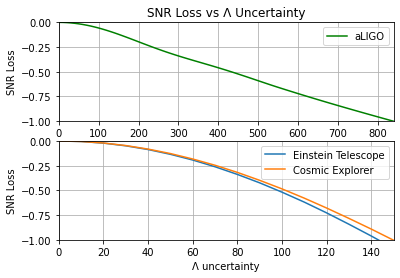

In [373]:
plt.subplot(2,1,1)
plt.title('SNR Loss vs Λ Uncertainty')

plt.plot(b,aL_SNRLoss,label='aLIGO',color = 'green')
plt.xlabel('Λ uncertainty')
plt.ylabel('SNR Loss')
plt.legend()
plt.ylim(-1,0) #change
plt.xlim(0,840)
plt.grid()

plt.subplot(2,1,2)
plt.plot(b,ET_SNRLoss,label='Einstein Telescope')
plt.plot(b,CE_SNRLoss,label='Cosmic Explorer')
plt.xlabel('Λ uncertainty') ##
plt.ylabel('SNR Loss')
plt.ylim(-1,0) #change
plt.xlim(0,150)
plt.legend()
plt.grid()

In [329]:
aL_df = pd.DataFrame(aL_SNRLoss)
aL_df.to_csv('aLIGO_DS1')

ET_df = pd.DataFrame(ET_SNRLoss)
ET_df.to_csv('ET_DS1')

CE_df = pd.DataFrame(CE_SNRLoss)
CE_df.to_csv('CE_DS1')